# Fusion des 2 modeles : Reconnaissance de text dans un formulaire
 

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd
import metric_orthograph as mo


# initialisation des variables globales
rss.init()



In [7]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)
reload(mo)

<module 'metric_orthograph' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\metric_orthograph.py'>

In [18]:
# MODELE DETECTION TEXTE

from doctr.models import ocr_predictor

DET_CKPT = "straight_model/weights"
form_img_path = '../data/formsA-D/a01-000u.png'

straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
straight_model.det_predictor.model.load_weights(DET_CKPT)
doc = DocumentFile.from_images(form_img_path)
coords = straight_model.det_predictor(doc)


print(coords)

  0%|          | 0/94178964 [00:00<?, ?it/s]

  0%|          | 0/58758994 [00:00<?, ?it/s]

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for straight_model/weights

0              A
1           MOVE
2             to
3           stop
4            Mr.
5      Gaitskell
6           from
7     nominating
8            any
9           more
10        Labour
11          life
12         Peers
13            is
14            to
15            be
16          made
17            at
18             a
19       meeting
Name: clean_trans, dtype: object


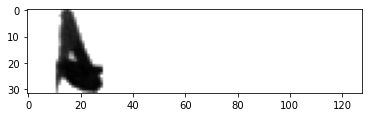

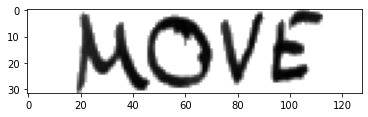

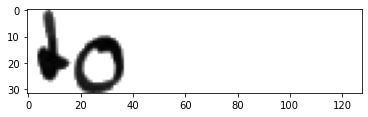

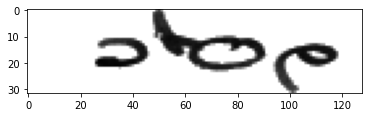

2023-02-13 16:57:15.443 WARNING tensorflow: 5 out of the last 5 calls to <function preprocess at 0x0000020DCB0C95E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


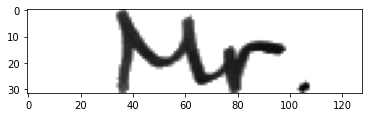

2023-02-13 16:57:15.737 WARNING tensorflow: 6 out of the last 6 calls to <function preprocess at 0x0000020DCB0C95E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


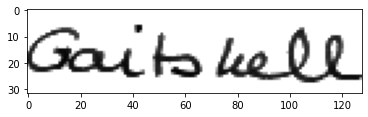

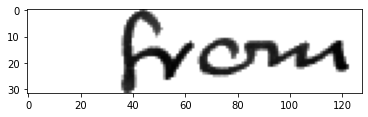

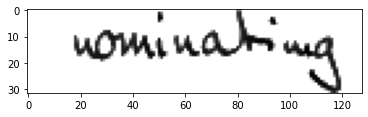

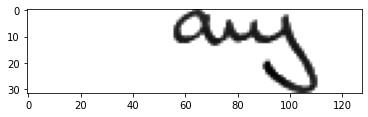

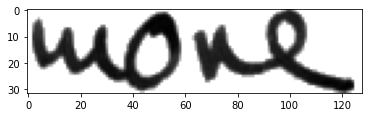

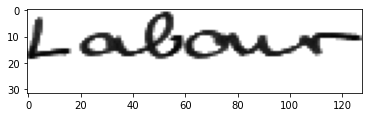

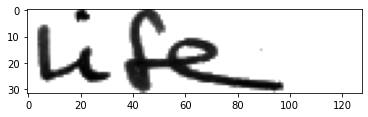

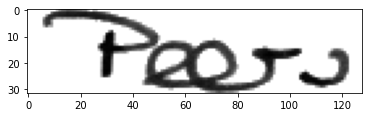

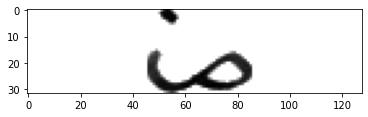

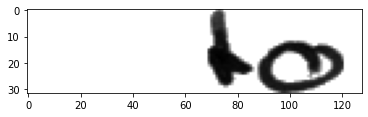

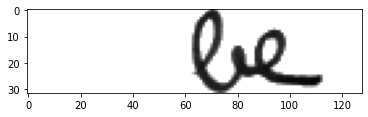

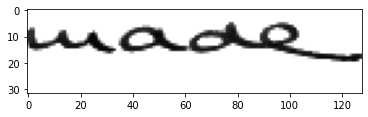

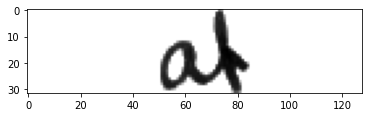

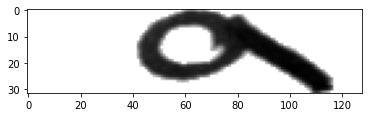

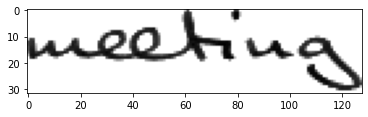

In [8]:

# Création du dataset pour la reconnaissance du texte : TODO prend en parametre le retour du modele de détection de texte

dataset = ld_util.get_dataset_for_prediction()


In [9]:
model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})

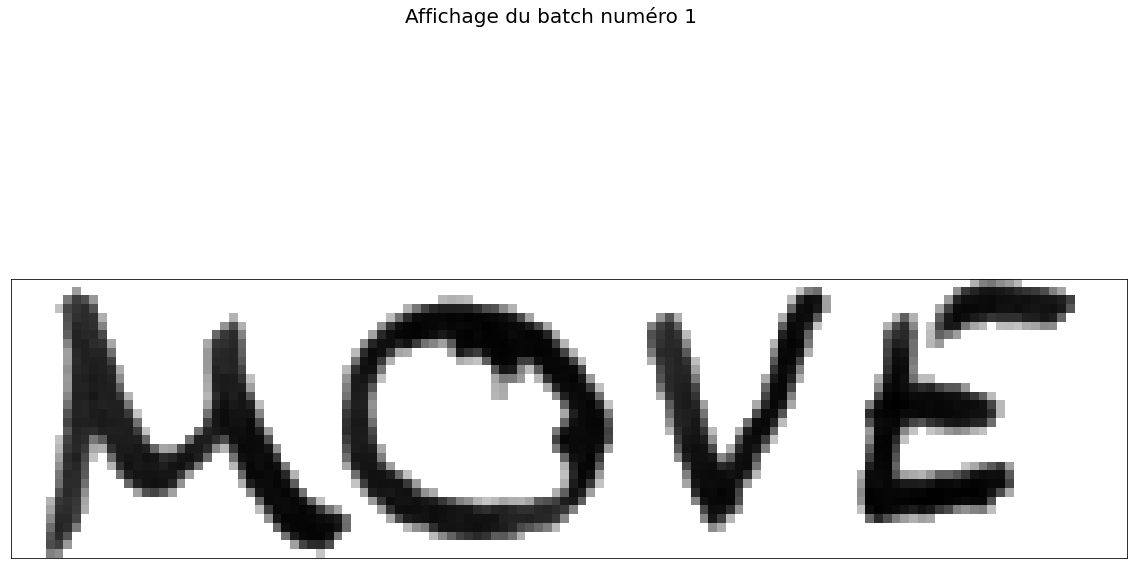

In [11]:
#TEST affichage d'un mot depuis formulaire avec dataset

batch_id=0
iterator = iter(dataset)

x = iterator.get_next()
batch_id +=1
# rd.show_iterator_batch(x,'y',batch_id, 4)

lin = 11
col = 6
fig = plt.figure(figsize=(20,12))
    
img = x[1]

plt.imshow(img,cmap='gray')
# plt.title(str(i)+' : '+str(liste_label[i]))
plt.xticks([], [])
plt.yticks([], [])
plt.suptitle('Affichage du batch numéro '+str(batch_id), size = 20);

In [12]:
# Utilisation du modele avec dataset formulaire
preds = model.predict(dataset)
mots = ld_util.greedy_decoder(preds, rss.charList)

print(mots)

4/4 [==============================] - 2s 185ms/step
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitskell', 'from', 'hominating', 'any', 'more', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a', 'meeting']
